# Support vector machines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, svm, model_selection as ms
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
CYCLE_HIRES_URL = 'https://files.datapress.com/london/dataset/number-bicycle-hires/2017-11-06T09:27:35.00/tfl-daily-cycle-hires.xls'

Read in the TfL Cycle Hire dataset.

In [3]:
hires = pd.read_excel(CYCLE_HIRES_URL, sheet_name='Data')

Convert `Day` to `datetime` and set as index.

In [4]:
hires['Day'] = pd.to_datetime(hires['Day'], unit='D')
hires.set_index('Day', inplace=True)

Extract first column (daily hires) and convert to `float`.

In [5]:
hires = hires.iloc[:, 0].astype(float).to_frame('Hires')

Apply logarithmic transformation.

In [6]:
hires['Hires'] = np.log10(hires['Hires'])

Create 7 new variables representing the lagged time series at lag = 1, ..., 7.

In [7]:
for lag in np.arange(1, 8):
    hires['HiresLag{}'.format(lag)] = hires['Hires'].shift(lag)

Create 2 new variables representing the smoothed time series (rolling averages at 7 and 30 days).

In [8]:
for window in [7, 30]:
    hires['HiresMA{}'.format(window)] = hires['Hires'].rolling(window).mean()

Drop missing values.

In [9]:
hires.dropna(inplace=True)

Define cross-validation split by leaving out 2017 as test set.

In [10]:
split = ms.PredefinedSplit(test_fold=(hires.index.year == 2017) - 1)

Create a pipeline that scales the data and trains a support vector regression model.

In [11]:
ssvc = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('svr', svm.SVR())
])

Fit the model.

In [12]:
X = hires.drop('Hires', axis=1)
y = hires.Hires
ssvc.fit(X, y)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

Compute MSE for split.

In [13]:
-ms.cross_val_score(ssvc, X, y, scoring='neg_mean_squared_error', cv=split)

array([ 0.00344681])

Determine 'optimal' kernel and value of `C` by cross-validation.

In [14]:
gs = ms.GridSearchCV(
    estimator=ssvc,
    param_grid={
        'svr__C': [1e-15, 0.0001, 0.001, 0.01, 0.1, 1, 10],
        'svr__kernel': ['linear', 'rbf']
    },
    scoring='neg_mean_squared_error',
    cv=split
)
gs.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': [1e-15, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'svr__kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
-gs.best_score_

0.0025282887084652496

In [16]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

Plot original time series and prediction from January 2016 onwards.

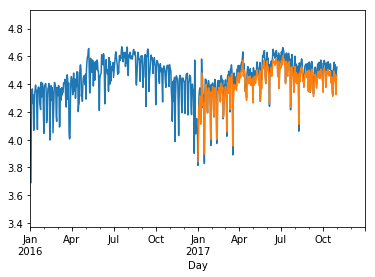

In [17]:
hires['Prediction'] = gs.best_estimator_.predict(X)
hires['Hires'].plot()
hires.loc[split.test_fold >= 0, 'Prediction'].plot(xlim=('2016-01-01', '2017-12-31'))